In [1]:
#imports 
import os
from collections import OrderedDict

import numpy as np
from tqdm import tqdm 
import pickle
from PIL import Image

import torch
import torchvision
import torch.distributed as dist
import torch.multiprocessing as multiprocessing
from multiprocessing import Process
from torchsummary import summary

from augmentation import *

In [2]:
#getting data
def VOCDataset(train_batch_size, val_batch_size):
    #code to download the dataset
    download_07 = os.path.exists('./data/VOCtrainval_06-Nov-2007.tar')
    download_12 = os.path.exists('./data/VOCtrainval_06-Nov-2012.tar')
    transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((448, 448), interpolation=2), 
        torchvision.transforms.ToTensor()])

    trainset_07 = torchvision.datasets.VOCDetection(root='./data', year='2007', 
                                             image_set='train',
                                        download=download_07, transforms=transform_labels(448, transform))
#     trainset_12 = torchvision.datasets.VOCDetection(root='./data', year='2012', 
#                                              image_set='train',
#                                         download=download_12, transforms=transform_labels(448, transform))
    valset_07 = torchvision.datasets.VOCDetection(root='./data', year='2007', 
                                             image_set='val',
                                       download=download_07, transforms=transform_labels(448, transform))
#     valset_12 = torchvision.datasets.VOCDetection(root='./data', year='2012', 
#                                              image_set='val',
#                                        download=download_12, transforms=transform_labels(448, transform))
    
#     trainset = torch.utils.data.ConcatDataset([trainset_07, trainset_12])
#     valset = torch.utils.data.ConcatDataset([valset_07, valset_12])
    trainloader = torch.utils.data.DataLoader(trainset_07, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valset_07, batch_size=val_batch_size,
                                         shuffle=True, num_workers=2, pin_memory=True)
    return trainloader, valloader

#make a transform class to transform the voc json labels 
#to	bounding box tensors 
class transform_labels(object):
    def __init__(self, image_shape, transform):
        self.resize = image_shape
        self.factor = (1, 1)
        self.transform = transform
#         self.augmentations = [hsv_augmentation, flip, translation, random_cropping]
        self.augmentations = [flip]
        self.class_dict = {'aeroplane' : 0,
                    'bicycle' : 1,
                    'bird' : 2,
                    'boat' : 3,
                    'bottle' : 4,
                    'bus' : 5,
                    'car' : 6,
                    'cat' : 7,
                    'chair' : 8,
                    'cow' : 9,
                    'diningtable' : 10,
                    'dog' : 11,
                    'horse' : 12,
                    'motorbike' : 13,
                    'person' : 14,
                    'pottedplant' : 15,
                    'sheep' : 16,
                    'sofa' : 17,
                    'train' : 18,
                    'tvmonitor' : 19}
    def __call__(self, img, target, grid_size=7):
        label = target
        shape_x = int(label['annotation']['size']['width'])
        shape_y = int(label['annotation']['size']['height'])
        self.factor = (1/shape_x, 1/shape_y)
        objects = label['annotation']['object']

        transformed_boxes = torch.zeros((7,7,6))
        if not isinstance(objects, list) :
            objects = list([objects])

        numpy_objects = []
        for obj in list(objects):
            bbox = [int(obj['bndbox']['xmin']),
                            int(obj['bndbox']['ymin']),
                            int(obj['bndbox']['xmax']),
                            int(obj['bndbox']['ymax']), 1, 
                            self.class_dict[obj['name']]]
            numpy_objects.append(bbox)
        objects = np.array(numpy_objects)
        augment = np.random.choice(self.augmentations)
#         if torch.randn(1) < 0:
#             img, bboxes = augment(np.asarray(img), np.array(numpy_objects))
#         else:
        img, bboxes  = np.asarray(img), np.array(numpy_objects)
        bboxes = to_center_dims_format(bboxes)
        bboxes[:,:4] = bboxes[:,:4] / np.tile([shape_x, shape_y], 2)

        for transformed_box in bboxes:
            coordx, coordy = int(transformed_box[0]*7), int(transformed_box[1]*7)
            transformed_box[0] = transformed_box[0]*7 - int(transformed_box[0]*7)
            transformed_box[1] = transformed_box[1]*7 - int(transformed_box[1]*7)
            transformed_boxes[coordy, coordx] = torch.tensor(transformed_box)


        return self.transform(Image.fromarray(img)), transformed_boxes.permute(2,0,1)

In [3]:
#network definition
n_boxes = 2
n_classes = 20
class conv_layer(torch.nn.Module):
    def __init__(self, in_maps, out_maps, kernel_size, stride, padding):
        super(conv_layer, self).__init__()
        self.conv = torch.nn.Conv2d(in_maps, out_maps, kernel_size,\
                                                     stride=stride, padding=padding )
        self.bn = torch.nn.BatchNorm2d(out_maps)
        #self.dropout = torch.nn.Dropout2d(p=0.5)

    def forward(self, x):
        x = self.conv(x)
        #x = self.dropout(x)
        x = self.bn(x)
        return torch.nn.functional.leaky_relu(x, negative_slope=0.1)

class conv_pool_block(torch.nn.Module):
    def __init__(self, kernel_sizes, in_maps, out_maps, n_repeat, pooling=False, conv_layer=conv_layer):
        assert len(kernel_sizes) == len(out_maps), 'Inconsistent kernel and filter lengths'

        super(conv_pool_block, self).__init__()
        self.layers = []
        for _ in range(n_repeat):
            self.layers.append(conv_layer(in_maps, out_maps[0], 
                                        kernel_sizes[0], stride=1, 
                                        padding = kernel_sizes[0]//2))
            for i in range(1, len(out_maps)):
                self.layers.append(conv_layer(out_maps[i-1], out_maps[i], 
                                        kernel_sizes[i], stride=1, 
                                        padding = kernel_sizes[i]//2))
        if pooling:
            self.layers.append(torch.nn.MaxPool2d(2,2))

        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)
    
class backbonenet(torch.nn.Module):
    def __init__(self):
        super(backbonenet, self).__init__()
        self.model = torch.nn.Sequential(conv_layer(3, 64, 7,stride=2, padding=3),
                                  torch.nn.MaxPool2d(2, stride=2), 
                                  conv_pool_block([3], 64, [192], 1, pooling=True), 
                                  conv_pool_block([1, 3, 1, 3], 192, 
                                      [128, 256, 256, 512],
                                      1, pooling=True),
                                  conv_pool_block([1, 3], 512, 
                                      [256, 512], 4), 
                                  conv_pool_block([1, 3], 512, 
                                      [512, 1024],
                                      1, pooling=True), 
                                  conv_pool_block([1, 3], 1024, 
                                      [512, 1024], 2),
                                  conv_pool_block([3], 1024, 
                                      [1024], 1), 
                                  conv_layer(1024, 1024, 3, stride=2, padding=1),
                                  conv_pool_block([3, 3], 1024, 
                                      [1024, 1024], 1))
   
    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), -1)


class yolonet(torch.nn.Module):
    def __init__(self, bbone=None):
        super(yolonet, self).__init__()
        if bbone is None:
            self.backbone = backbonenet()
        else :
            self.backbone = bbone 
        self.Linear1 = torch.nn.Linear(49*1024, 4096)
        self.Linear2 = torch.nn.Linear(4096, 49*(n_boxes*5 + n_classes))
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear2(x)
        return x.view((x.size(0), 30, 7, 7))

class yolonet_classification(torch.nn.Module):
    def __init__(self):
        super(yolonet_classification, self).__init__()
        self.backbone = backbonenet() 
        self.Linear = torch.nn.Linear(49*1024, 100)

    def forward(self, x):
        x = self.backbone(x)
        return self.Linear(x)

In [4]:
#loss function
class yolov1loss(torch.nn.Module):

    def __init__(self, lambda_coord, lambda_noobj, device):
        super(yolov1loss, self).__init__()
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.device = device

    def forward(self, x, labels):
        #evaluating coordinate loss
        loss = 0
        
        box1, box2, class_predictions = x.split([5, 5, 20], dim=1)
        box1 = torch.sigmoid(box1)
        box2 = torch.sigmoid(box2)
        label_box, class_labels = labels.split([5, 1], dim=1)
        label_coords, label_dims, object_mask = label_box.split([2, 2, 1], dim=1)
        
        num_boxes = torch.sum(object_mask, dim=[1,2,3]) + 1e-6
        class_predictions = torch.softmax(class_predictions, dim=1)
        class_labels = class_labels.type(torch.int64)
        onehotlabels = torch.zeros([labels.shape[0], 20, labels.shape[2],
                                labels.shape[3]], device=self.device).scatter(1, class_labels, object_mask)
        loss = torch.mean(torch.sum((object_mask*class_predictions - onehotlabels)**2, dim=[1,2,3]))

#         loss = torch.mean((object_mask*class_predictions - onehotlabels)**2)

        box_confs = torch.cat([self.IoU(box1, label_box), self.IoU(box2, label_box)], 1)
        argmax_conf = torch.argmax(box_confs, 1, keepdim=True).detach()
        argmax_conf = argmax_conf.type(torch.float)

        
        box1_coords, box1_dims, box1_confs = box1.split([2,2,1], dim=1)
        box2_coords, box2_dims, box2_confs = box2.split([2,2,1], dim=1)
        box1_dims = torch.sqrt(box1_dims + 1e-6)
        box2_dims = torch.sqrt(box2_dims + 1e-6)
        label_dims = torch.sqrt(label_dims + 1e-6)


#         final_box_coords = (1-argmax_conf)*box1_coords + argmax_conf*box2_coords
#         loss += self.lambda_coord * (torch.mean((
#                                                         object_mask*final_box_coords - label_coords)**2))

#         final_box_dims = (1-argmax_conf)*box1_dims + argmax_conf*box2_dims
#         loss += self.lambda_coord * (torch.mean(( 
#                                                         object_mask*final_box_dims - label_dims)**2))

        final_box_coords = (1-argmax_conf)*box1_coords + argmax_conf*box2_coords
        loss += self.lambda_coord * (torch.mean(torch.sum((
                                                        object_mask*final_box_coords - label_coords)**2, dim=[1,2,3]) ))

        final_box_dims = (1-argmax_conf)*box1_dims + argmax_conf*box2_dims
        loss += self.lambda_coord * (torch.mean(torch.sum(( 
                                                        object_mask*final_box_dims - label_dims)**2, dim=[1,2,3])))

        final_box_obj = (1-argmax_conf)*box1_confs + argmax_conf*box2_confs
        object_mask = object_mask.type(torch.float)
        loss += torch.mean(torch.sum((object_mask*final_box_obj - object_mask)**2, dim=[1,2,3]))
        
#         loss += torch.mean((object_mask*final_box_obj - object_mask)**2)
        #no obj loss
        rejected_boxes =(1-argmax_conf)*box2_confs + argmax_conf*box1_confs
        loss += self.lambda_noobj*torch.mean(torch.sum(
                                                ((1-object_mask)*final_box_obj)**2 
                                                + (rejected_boxes)**2, dim=[1,2,3]))
#         loss += self.lambda_noobj*torch.mean(
#                                                 ((1-object_mask)*final_box_obj)**2 
#                                                 + (rejected_boxes)**2)
        return loss
    
    def Intersection(self, bb1: torch.Tensor, bb2:torch.tensor) -> torch.Tensor:
        '''
        '''
        x = torch.tensor(torch.arange(7)).to(bb1.device)
        y = torch.tensor(torch.arange(7)).to(bb1.device)
        grid_x, grid_y = torch.meshgrid(x, y)
        grid = torch.cat([grid_y.unsqueeze(0), grid_x.unsqueeze(0)], 0).type(torch.float)

        def return_mins_maxs(bbx):
            centers, dims, _ = bbx.split([2,2,1], 1)
            centers = (centers + grid)/7
            return centers-dims/2 , centers+dims/2

        mins1, maxs1 = return_mins_maxs(bb1)
        mins2, maxs2 = return_mins_maxs(bb2)
        mins = torch.max(mins1, mins2)
        maxs = torch.min(maxs1, maxs2)
        diff = (maxs - mins).clamp(0)
        return diff[:, 0, : , :] * diff[:, 1, :, :]
    
    def bbox_area(self, bbx):
        return bbx[:, 2, :, :] * bbx[:, 3, :, :]
    
    def IoU(self, bb1, bb2):
        '''Evaluate the IoU score
        '''
        intersection = self.Intersection(bb1, bb2)
        return (intersection / (self.bbox_area(bb1) + self.bbox_area(bb2) - intersection)).unsqueeze(1)

In [5]:
configs = {'train_batch': 128, 
            'val_batch':128,
           'n_epochs': 100,
            'result_frequency': 5,
           'val_frequency': 5,
        }

In [6]:
#loading yolonet pretrained on cifar100 dataset
def load_pretrained_cf100():
    chkpt = torch.load('checkpoint.pth.tar')
    state_dict = chkpt['state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if not k[7:15] == 'backbone':
            continue
        name = k[16:] # remove `module.`
        new_state_dict[name] = v
    bbnet = backbonenet()
    bbnet.load_state_dict(new_state_dict)
    del chkpt
    torch.cuda.empty_cache()
    net = yolonet(bbnet)
    return net

In [7]:
#resume training 
def resume_train(net, model_path, optimizer):
    checkpoint = torch.load(model_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    del checkpoint
    torch.cuda.empty_cache()
    print('----successfully loaded network and training parameters---')
    return net, optimizer, epoch

In [8]:
#training 
#make a network object
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch = 0
net = yolonet()
net = net.to(device)
print(summary(net, (3,448,448)))
    
net = torch.nn.DataParallel(net)
loss = yolov1loss(lambda_coord=5, lambda_noobj=0.5, device=device)

# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

net, optimizer, epoch = resume_train(net, 'chkpt_files/yolov1_model_sgd_500.pth', optimizer)


traindata, valdata = VOCDataset(configs['train_batch'], configs['val_batch'])
train_loss, val_loss= [], []
for i in range(epoch, epoch + configs['n_epochs'], 1):
    trainiter = iter(traindata)
    net.train()
    for _ in tqdm(range(len(trainiter)), ncols=100):
        x, y = trainiter.next()
        x, y = x.to(device), y.to(device)
        y_hat = net(x)
        loss_ = loss(y_hat, y)
        for p in net.parameters():
            loss_ += 0.01 * torch.sum(p**2)
        train_loss.append(loss_.item())
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()

    print('training loss after {}/{} epochs is {}'.format(
        i + 1, epoch + configs['n_epochs'], np.mean(train_loss[-len(trainiter):])))

    if i % configs['val_frequency'] == 0:
        valiter = iter(valdata)
        net.eval()
        with torch.no_grad():
            for _ in tqdm(range(len(valiter)), ncols=100):
                x, y = valiter.next()
                x, y = x.to(device), y.to(device)
                y_hat = net(x)
                loss_ = loss(y_hat, y)
                for p in net.parameters():
                    loss_ += 0.01 * torch.sum(p**2)
                val_loss.append(loss_.item())

            print('validation loss after {}/{} epochs is {}'.format(
                i + 1, epoch + configs['n_epochs'], np.mean(val_loss[-len(valiter):])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
       BatchNorm2d-2         [-1, 64, 224, 224]             128
        conv_layer-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 192, 112, 112]         110,784
       BatchNorm2d-6        [-1, 192, 112, 112]             384
        conv_layer-7        [-1, 192, 112, 112]               0
         MaxPool2d-8          [-1, 192, 56, 56]               0
   conv_pool_block-9          [-1, 192, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]          24,704
      BatchNorm2d-11          [-1, 128, 56, 56]             256
       conv_layer-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
      BatchNorm2d-14          [-1, 256,

  0%|                                                                        | 0/20 [00:00<?, ?it/s]/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|███████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  1.31it/s]

training loss after 501/600 epochs is 5.481702280044556



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

validation loss after 501/600 epochs is 11.913359260559082



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 502/600 epochs is 5.462692785263061



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

training loss after 503/600 epochs is 5.416497802734375



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 504/600 epochs is 5.375605535507202



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 505/600 epochs is 5.334034037590027



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 506/600 epochs is 5.321724867820739



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

validation loss after 506/600 epochs is 11.802377891540527



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

training loss after 507/600 epochs is 5.305534863471985



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.40it/s]

training loss after 508/600 epochs is 5.278241801261902



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 509/600 epochs is 5.251468181610107



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.29it/s]

training loss after 510/600 epochs is 5.2240598678588865



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 511/600 epochs is 5.193059301376342



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

validation loss after 511/600 epochs is 11.814967155456543



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

training loss after 512/600 epochs is 5.16059296131134



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

training loss after 513/600 epochs is 5.121831560134888



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 514/600 epochs is 5.103952646255493



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 515/600 epochs is 5.069627737998962



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 516/600 epochs is 5.044210004806518



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

validation loss after 516/600 epochs is 11.533777856826783



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 517/600 epochs is 5.022794008255005



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 518/600 epochs is 4.997155380249024



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 519/600 epochs is 4.971318101882934



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 520/600 epochs is 4.948161482810974



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 521/600 epochs is 4.937486028671264



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.44it/s]

validation loss after 521/600 epochs is 11.402235889434815



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 522/600 epochs is 4.9105465650558475



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.36it/s]

training loss after 523/600 epochs is 4.874760532379151



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

training loss after 524/600 epochs is 4.855928206443787



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 525/600 epochs is 4.830363368988037



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 526/600 epochs is 4.8141197681427



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

validation loss after 526/600 epochs is 11.296781778335571



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 527/600 epochs is 4.786330842971802



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 528/600 epochs is 4.7543230056762695



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 529/600 epochs is 4.730507016181946



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 530/600 epochs is 4.700430226325989



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 531/600 epochs is 4.683140540122986



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.42it/s]

validation loss after 531/600 epochs is 11.22662935256958



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 532/600 epochs is 4.659038782119751



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

training loss after 533/600 epochs is 4.614344739913941



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 534/600 epochs is 4.615367650985718



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.37it/s]

training loss after 535/600 epochs is 4.60912344455719



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 536/600 epochs is 4.571774029731751



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.41it/s]

validation loss after 536/600 epochs is 11.12436318397522



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 537/600 epochs is 4.563790917396545



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 538/600 epochs is 4.536774945259094



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.35it/s]

training loss after 539/600 epochs is 4.513073348999024



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 540/600 epochs is 4.49687922000885



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 541/600 epochs is 4.484888005256653



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

validation loss after 541/600 epochs is 10.970341777801513



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.37it/s]

training loss after 542/600 epochs is 4.4516401290893555



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 543/600 epochs is 4.430106949806214



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 544/600 epochs is 4.410582804679871



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.29it/s]

training loss after 545/600 epochs is 4.393107628822326



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.35it/s]

training loss after 546/600 epochs is 4.371086072921753



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.42it/s]

validation loss after 546/600 epochs is 10.941316318511962



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.38it/s]

training loss after 547/600 epochs is 4.355166864395142



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 548/600 epochs is 4.335362219810486



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 549/600 epochs is 4.318473815917969



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 550/600 epochs is 4.290651440620422



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 551/600 epochs is 4.282381653785706



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

validation loss after 551/600 epochs is 10.893725490570068



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 552/600 epochs is 4.259786367416382



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 553/600 epochs is 4.230270552635193



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 554/600 epochs is 4.202814364433289



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.33it/s]

training loss after 555/600 epochs is 4.206844139099121



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.38it/s]

training loss after 556/600 epochs is 4.196788620948792



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.41it/s]

validation loss after 556/600 epochs is 10.716601514816285



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

training loss after 557/600 epochs is 4.177197456359863



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 558/600 epochs is 4.13474223613739



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 559/600 epochs is 4.109179413318634



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.41it/s]

training loss after 560/600 epochs is 4.1033306360244755



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

training loss after 561/600 epochs is 4.087707877159119



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.44it/s]

validation loss after 561/600 epochs is 10.571310138702392



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 562/600 epochs is 4.066605544090271



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 563/600 epochs is 4.043851041793824



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

training loss after 564/600 epochs is 4.037775278091431



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.35it/s]

training loss after 565/600 epochs is 4.031006038188934



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.39it/s]

training loss after 566/600 epochs is 4.009300589561462



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.31it/s]

validation loss after 566/600 epochs is 10.566197633743286



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 567/600 epochs is 3.988069200515747



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 568/600 epochs is 3.971183145046234



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 569/600 epochs is 3.9741873502731324



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 570/600 epochs is 3.9563493490219117



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 571/600 epochs is 3.9429229497909546



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

validation loss after 571/600 epochs is 10.442379760742188



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.28it/s]

training loss after 572/600 epochs is 3.921854889392853



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 573/600 epochs is 3.898692238330841



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.31it/s]

training loss after 574/600 epochs is 3.8967715740203857



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 575/600 epochs is 3.8761120796203614



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 576/600 epochs is 3.8600103855133057



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.38it/s]

validation loss after 576/600 epochs is 10.365943145751952



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 577/600 epochs is 3.859845817089081



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 578/600 epochs is 3.840277361869812



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.38it/s]

training loss after 579/600 epochs is 3.8317978024482726



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.41it/s]

training loss after 580/600 epochs is 3.805917978286743



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 581/600 epochs is 3.8061747670173647



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

validation loss after 581/600 epochs is 10.334262132644653



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.34it/s]

training loss after 582/600 epochs is 3.792138934135437



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 583/600 epochs is 3.7585899114608763



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.32it/s]

training loss after 584/600 epochs is 3.737526571750641



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.37it/s]

training loss after 585/600 epochs is 3.740265655517578



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.33it/s]

training loss after 586/600 epochs is 3.7222957491874693



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

validation loss after 586/600 epochs is 10.319139957427979



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 587/600 epochs is 3.7341561317443848



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.34it/s]

training loss after 588/600 epochs is 3.7082245111465455



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 589/600 epochs is 3.6766258120536803



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.35it/s]

training loss after 590/600 epochs is 3.670287299156189



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.38it/s]

training loss after 591/600 epochs is 3.6722805380821226



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.43it/s]

validation loss after 591/600 epochs is 10.255770540237426



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.29it/s]

training loss after 592/600 epochs is 3.6401134371757506



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 593/600 epochs is 3.6299740791320803



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.36it/s]

training loss after 594/600 epochs is 3.6159583568572997



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.35it/s]

training loss after 595/600 epochs is 3.6004641175270082



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.37it/s]

training loss after 596/600 epochs is 3.592414748668671



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

validation loss after 596/600 epochs is 10.199878358840943



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 597/600 epochs is 3.5785424590110777



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.39it/s]

training loss after 598/600 epochs is 3.564551663398743



100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.36it/s]

training loss after 599/600 epochs is 3.5429030299186706



100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.37it/s]

training loss after 600/600 epochs is 3.5587374567985535


In [9]:
def save_model(net, optimizer, i, path):
    #saving model to checkpoint 
    torch.save({
            'epoch': i + 1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
save_model(net, optimizer, i, 'chkpt_files/yolov1_model_sgd_600.pth')

In [10]:
#nms
def IoU(bb1, bb2):
    '''
    bb1 : input bounding box 1 the coordinates corresponds to 
          center_x center_y width height
    bb2 : bounding box 2 coordinates in the same order as bb1
    '''
    minx = max(bb1[0] - bb1[2] / 2, bb2[0] - bb2[2] / 2)
    maxx = min(bb1[0] + bb1[2] / 2, bb2[0] + bb2[2] / 2)
    miny = max(bb1[1] - bb1[3] / 2, bb2[1] - bb2[3] / 2)
    maxy = min(bb1[1] + bb1[3] / 2, bb2[1] + bb2[3] / 2)
    diffx = (maxx - minx) #- (bb1[2] + bb2[2]) 
    diffy = (maxy - miny) #- (bb1[3] + bb2[3])
    if diffx > 0  and diffy >  0 :
        intersection = diffx * diffy
        return intersection / (bb1[2] * bb1[3] + bb2[2] * bb2[3] - intersection) 
    return 0

def non_max_suppression(predicted_tensor, iou_threshold=0.6, obj_threshold=0.25):
    #grid coordinates to add to predicted offset
    predicted_tensor = predicted_tensor.cpu()
    x = torch.tensor(torch.arange(7))
    y = torch.tensor(torch.arange(7))
    grid_x, grid_y = torch.meshgrid(x, y)
    box1, box2, classes = predicted_tensor.split([5, 5, 20], 1)
    box1 = torch.sigmoid(box1)
    box2 = torch.sigmoid(box2)
    classes = torch.argmax(classes, 1, keepdim=True).type(torch.float)
    grid = torch.cat([grid_y.unsqueeze(0), grid_x.unsqueeze(0)], 0).type(torch.float)
    box1_coords, box1_dims, box1_confs = box1.split([2,2,1], 1)
    box2_coords, box2_dims, box2_confs = box2.split([2,2,1], 1)
    box1_coords = (box1_coords + grid)/7
    box2_coords = (box2_coords + grid)/7

    box1 = torch.cat([box1_coords, box1_dims, box1_confs, classes], dim=1).permute(0, 2, 3, 1)
    box2 = torch.cat([box2_coords, box2_dims, box2_confs, classes], dim=1).permute(0, 2, 3, 1)
    box1 = box1.view(box1.shape[0], -1, box1.shape[3])
    box2 = box2.view(box2.shape[0], -1, box2.shape[3]) 
    boxes = torch.cat([box1, box2], 1).numpy()
    obj_mask = boxes[:, :, 4] >= obj_threshold
    selected_boxes = []

    for box, mask in zip(boxes, obj_mask):
        mask = mask.reshape(-1)
        this_boxes = []
        temp_boxes = []
        for i in range(mask.shape[0]):
            if mask[i]:
                temp_boxes.append(box[i])

        box = sorted(temp_boxes, key=lambda a:a[-2])
        box = box[::-1]
        box_list = [[] for _ in range(20)]
        for i in range(len(box)):
            box_list[int(box[i][-1])].append(box[i]) 
        for sorted_ in box_list:
            while len(sorted_) > 0:
                this_box = sorted_[0]
                del sorted_[0]
                sorted_new = []
                for i in range(len(sorted_)):
                    if IoU(this_box, sorted_[i]) < iou_threshold:
                        sorted_new.append(sorted_[i])

                sorted_ = sorted_new
                this_box[4] = 1
                this_boxes.append(this_box)
        selected_boxes.append(torch.tensor(this_boxes))
    return selected_boxes

In [11]:
#utils 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from class_names import class_names

color_dict = np.random.rand(20,3)
def visualize_bbox_labels(image, label_tensor, bboxes, save_path):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    if isinstance(image, torch.Tensor):
        ax1.imshow(image.permute(1,2,0))
        ax2.imshow(image.permute(1,2,0))
        scale_x, scale_y = image.size(1), image.size(2)
    else:
        ax1.imshow(image)
        ax2.imshow(image)
        scale_x, scale_y = image.shape[0], image.shape[1]

    if len(list(bboxes.shape)) <  2:
        if save_path is not None :
            plt.savefig(save_path) 
            return 
        if torch.max(label_tensor) > 1:
            label_tensor[:, :2] /= torch.tensor([scale_x, scale_y], dtype=torch.float32)
            label_tensor[:, 2:4] /= torch.tensor([scale_x, scale_y], dtype=torch.float32)

    if len(list(label_tensor.shape)) == 3:
        print ('recieved true labels')
        x = torch.tensor(torch.arange(7))
        y = torch.tensor(torch.arange(7))
        grid_x, grid_y = torch.meshgrid(x, y)
        grid = torch.cat([grid_y.unsqueeze(0), grid_x.unsqueeze(0)], 0).type(torch.float)
        label_tensor[:2,:,:] += grid 
        label_tensor[:2,:,:] /= 7
        label_tensor = label_tensor.permute(1, 2, 0)
        object_mask = label_tensor[:, :, 4] == 1
        object_mask = object_mask.unsqueeze(dim=-1).expand(label_tensor.shape)
        #arrange the values into a tensor of box coordinates 
        label_tensor = label_tensor[object_mask].view((-1, 6))

    centers = label_tensor[:,:2]
    sizes = label_tensor[:,2:4]
    label_tensor[:,:2] = centers - sizes / 2
    label_tensor[:,:2] = label_tensor[:,:2] * torch.tensor([scale_x, scale_y], dtype=torch.float32)
    label_tensor[:,2:4] = label_tensor[:,2:4] * torch.tensor([scale_x, scale_y], dtype=torch.float32)
    label_tensor = label_tensor.to(torch.int16)

    for i in range(label_tensor.size(0)):
        ax1.add_patch(patches.Rectangle((label_tensor[i, 0], label_tensor[i, 1]),
                                                        label_tensor[i, 2], label_tensor[i, 3], 
                                                        color=color_dict[label_tensor[i, 5]], fill=False))
        ax1.text(label_tensor[i, 0], label_tensor[i, 1], class_names[label_tensor[i, 5]] ,fontsize=20, color=color_dict[label_tensor[i, 5]])

    centers = bboxes[:,:2]
    sizes = bboxes[:,2:4]
    bboxes[:,:2] = centers - sizes / 2
    bboxes[:,:2] = bboxes[:,:2] * torch.tensor([scale_x, scale_y], dtype=torch.float32)
    bboxes[:,2:4] = bboxes[:,2:4] * torch.tensor([scale_x, scale_y], dtype=torch.float32)
    bboxes = bboxes.to(torch.int16)
    for i in range(bboxes.size(0)):
        ax2.add_patch(patches.Rectangle((bboxes[i, 0],bboxes[i, 1]),
                                                        bboxes[i, 2], bboxes[i, 3], 
                                                        color=color_dict[bboxes[i, 5]], fill=False))
        ax2.text(bboxes[i, 0], bboxes[i, 1], class_names[bboxes[i, 5]] ,fontsize=20, color=color_dict[bboxes[i, 5]])

    if save_path is not None:
        plt.savefig(save_path)
    else :
        fig.canvas.draw()
        return np.array(fig.canvas.renderer.buffer_rgba()) 


/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it

recieved true labels


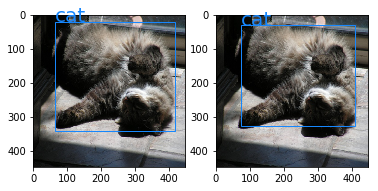

In [12]:
 #inference
net.eval()
j = 4
with torch.no_grad():
    suppressed_preds = non_max_suppression(y_hat[j].unsqueeze(0))
    if not len(suppressed_preds[0]) == 0:
        save_path = 'results/val_preds_e{}.png'.format(i + 1)
        visualize_bbox_labels(x[j].to('cpu'), y[j].to('cpu'), suppressed_preds[0], save_path)


/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it

recieved true labels


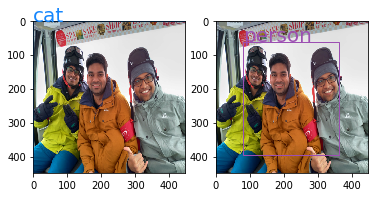

In [15]:
img = Image.open('test_images/test_jibun.jpg')
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((448, 448), interpolation=2), 
        torchvision.transforms.ToTensor()])
img = transform(img).unsqueeze(0).to(device)
net.eval()
with torch.no_grad():
    ypred = net(img)
    suppressed_preds = non_max_suppression(ypred)
    if not len(suppressed_preds[0]) == 0:
        save_path = 'results/val_preds_e{}.png'.format(i + 1)
        visualize_bbox_labels(img[0].to('cpu'), y[0].to('cpu'), suppressed_preds[0], save_path)


In [21]:

traindata, valdata  = VOCDataset(32, 32)
trainiter = iter(valdata)
x , y = trainiter.next()

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar


In [22]:
#nn sanity check
samplex = x[0 : 16]
sampley = y[0 : 16]

# device = 'cuda:0'
# net = yolonet()
# net = net.to(device)
# net.train()
# # net = torch.nn.DataParallel(net)
# loss = yolov1loss(lambda_coord=5, lambda_noobj=0.5, device=device)

# # optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

# for i in range(500):
#     samplex, sampley = samplex.to(device), sampley.to(device)
#     sampley_hat = net(samplex)
#     loss_ = loss(sampley_hat, sampley)
#     for p in net.parameters():
#         loss_ += 0.001 * torch.sum(p**2)
#     optimizer.zero_grad()
#     loss_.backward()
#     optimizer.step()

#     print('training loss after {}/{} epochs is {}'.format(
#         i + 1, 500, loss_.item()))

/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it

recieved true labels


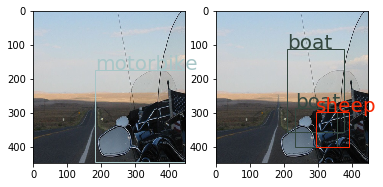

In [33]:
 #inference
net.eval()
j = 7
predy_hat = net(samplex[j].unsqueeze(0))
with torch.no_grad():
    suppressed_preds = non_max_suppression(predy_hat)
    if not len(suppressed_preds[0]) == 0:
        save_path = 'results/val_preds_e{}.png'.format(i + 1)
        visualize_bbox_labels(samplex[j].to('cpu'), sampley[j].to('cpu'), suppressed_preds[0], save_path)


In [12]:
torch.mean(torch.randn(10) /(10 - torch.randn(10)))

tensor(0.0204)

In [11]:
(10 - torch.randn(10))

tensor([11.3561,  9.5818, 10.0950, 10.0692,  9.9318, 10.6840, 10.1370, 10.2192,
        11.8371, 10.1633])